In [1]:
import pickle

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor    

%matplotlib inline

In [2]:
with open('/home/arash/ProjectVR/cleaneddata/ALLDATA', 'rb') as f:
    data=pickle.load(f)
    
data=data.loc[-data['Wait Time (s)'].isin(['Err1','Err2','Err3','Err4','Err5'])]
data=data.loc[data['Age_9-12'].isin([0,1])]


data=data.loc[:,['Wait Time (s)','Speed Limit', 'Lane Width', 'Minimum Gap', 'Mean Arrival Rate', 'AV', 
                    'Snowy',
                   'One way', 'two way', 'Two way with median', 'Night', 'numcars', 
                    'Age_9-12', 'Age_15-18', 'Age_12-15', 'Age_18 - 24', 'Age_25 - 29', 'Age_30 - 39', 'Age_50 - 59',
                 'Age_60+', 'Gender_Female', 'Occupation_Employed', 'Occupation_Student', 'Occupation_Unemployed', 
                   'Occupation_kid', 'driving license_Yes', 'mode_Bike', 'mode_Car',
                   'mode_Public Transit', 'mode_Walking', 'workwalk_No', 'workwalk_Sometimes', 'workwalk_Yes', 
                   'shopwalk_No', 'shopwalk_Sometimes', 'shopwalk_Yes', 'Vrexp_Yes']]       #numwalk and VRexpnum removed because of some false inputs in the data should be fixed later



data=pd.get_dummies(data=data,columns=['Speed Limit','Lane Width','Minimum Gap','Mean Arrival Rate','numcars'])

data['numcars_morethan1']=data['numcars_2']+data['numcars_3']+data['numcars_4']

data=data.drop(columns=['numcars_2','numcars_3','numcars_4'])

data=data.apply(pd.to_numeric, errors='coerce')


def FullAV(row):
    if row['AV']==100:
        return 1
    else:
        return 0
def MixedAV(row):
    if row['AV']>0 and row['AV']<100:
        return 1
    else:
        return 0   
def HDV(row):
    if row['AV']==0:
        return 1

    else:
        return 0   
data=data[data.Occupation_kid==0]                         #remove kids


data['FullAV']=data.apply (lambda row: FullAV(row), axis=1)
data['Mixed']=data.apply (lambda row: MixedAV(row), axis=1)
#data['HDV']=data.apply (lambda row: HDV(row), axis=1)
data['over50']=data['Age_50 - 59']+data['Age_60+']
data=data.drop(columns=['Age_9-12', 'Age_15-18', 'Age_12-15','Occupation_kid','AV','Age_50 - 59','Age_60+'])




 #the value in the middle is removed for more than two level features
data=data.drop(columns=['two way', 'Occupation_Unemployed',                  
                        'mode_Bike','workwalk_Sometimes','shopwalk_Sometimes',
                        'Speed Limit_40.0','Lane Width_2.75','Minimum Gap_1.5','Mean Arrival Rate_750.0'
                        ,'numcars_1'])

# check if we have collinear variables
def calculate_vif_(X, thresh=50.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

data=calculate_vif_(data, thresh=50.0)

data['E']=1

Remaining variables:
Index(['Wait Time (s)', 'Snowy', 'One way', 'Two way with median', 'Night',
       'Age_18 - 24', 'Age_25 - 29', 'Age_30 - 39', 'Gender_Female',
       'Occupation_Employed', 'Occupation_Student', 'driving license_Yes',
       'mode_Car', 'mode_Public Transit', 'mode_Walking', 'workwalk_No',
       'workwalk_Yes', 'shopwalk_No', 'shopwalk_Yes', 'Vrexp_Yes',
       'Speed Limit_30.0', 'Speed Limit_50.0', 'Lane Width_2.5',
       'Lane Width_3.0', 'Minimum Gap_1.0', 'Minimum Gap_2.0',
       'Mean Arrival Rate_530.0', 'Mean Arrival Rate_1100.0', 'numcars_0',
       'numcars_morethan1', 'FullAV', 'Mixed', 'over50'],
      dtype='object')


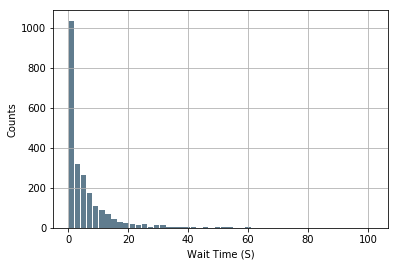

In [3]:
# Wait time freq table.

size, scale = 1000, 10
waittimes = pd.Series(data['Wait Time (s)'])

waittimes.plot.hist(grid=True, bins=50, rwidth=0.9,
                   color='#607c8e')
#plt.title('Waiting Time frequency distribution for all participants')
plt.xlabel('Wait Time (S)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=1)
plt.savefig('waitfreq.pdf')

In [ ]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/datanorelieff', 'wb') as f:
    pickle.dump(data,f) 

### Go to feature selection, sort data columns based on importance, and reload the data

In [ ]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/data', 'rb') as f:
    data=pickle.load(f) 

In [20]:
train, test = train_test_split(data,test_size=0.2, random_state=1)
             
#20 percent of data is seperated for test set
NCtrain=train   
NCtest= test
#NC: Not changed, used later for shap, without a format change that deepsurv requires

trainsub, valsub = train_test_split(train,test_size=0.2, random_state=1)  
#20 percent of train data is selected for validation set, 
#for cross-validation train is used,
#for network training using opt_params, trainsub and valsub are used

In [21]:
def dataframe_to_deepsurv_ds(df, event_col = 'E', time_col = 'Wait Time (s)'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

In [22]:
train=dataframe_to_deepsurv_ds(train)
test=dataframe_to_deepsurv_ds(test)
trainsub = dataframe_to_deepsurv_ds(trainsub)
valsub = dataframe_to_deepsurv_ds(valsub)

In [23]:
xtrain = train['x']
etrain = train['e']
ttrain = train['t']
ytrain = np.column_stack((etrain, ttrain))

In [24]:
xtest = test['x']
etest = test['e']
ttest = test['t']
ytest = np.column_stack((etest, ttest))

In [25]:
xtrainsub = trainsub['x']
etrainsub = trainsub['e']
ttrainsub = trainsub['t']
ytrainsub = np.column_stack((etrainsub, ttrainsub))

In [26]:
xvalsub = valsub['x']
evalsub = valsub['e']
tvalsub = valsub['t']
yvalsub = np.column_stack((evalsub, tvalsub))

In [36]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'wb') as f:
    pickle.dump(xtrain,f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytrain', 'wb') as f:
    pickle.dump(ytrain,f)  
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtest', 'wb') as f:
    pickle.dump(xtest,f)   

with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytest', 'wb') as f:
    pickle.dump(ytest,f)   

In [37]:

with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrainsub', 'wb') as f:
    pickle.dump(xtrainsub,f)   
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytrainsub', 'wb') as f:
    pickle.dump(ytrainsub,f) 
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xvalsub', 'wb') as f:
    pickle.dump(xvalsub,f) 
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/yvalsub', 'wb') as f:
    pickle.dump(yvalsub,f) 

In [ ]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'wb') as f:
    pickle.dump(NCtrain,f)  
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctest', 'wb') as f:
    pickle.dump(NCtest,f) 